# Portfolio Optimization

Questo notebook userà tutto ciò che vediamo sulla portfolio optimization, ma sui dati reali di S&P500

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/sp500sub.csv", parse_dates=True, index_col="Date")

In [3]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Name'], dtype='object')

In [4]:
df["Name"].unique()

array(['INCY', 'GILD', 'DXC', 'AFL', 'XYL', 'ARE', 'AMD', 'WYNN', 'IBM',
       'ATVI', 'AES', 'GPC', 'PRU', 'HST', 'WMB', 'GOOG', 'SRE', 'HSIC',
       'UNP', 'UPS', 'K', 'LYB', 'MDT', 'COF', 'HAS', 'CSX', 'GT', 'SYF',
       'EBAY', 'KSS', 'AJG', 'JWN', 'SBUX', 'IT', 'PH', 'DVN', 'MMM',
       'SPG', 'AKAM', 'IP', 'CPB', 'KMI', 'AAPL', 'NEM', 'KMX', 'TSCO',
       'SYY', 'VNO', 'NWS', 'NBL', 'ACN', 'APH', 'PDCO', 'WLTW', 'FIS',
       'URI', 'CBOE', 'FISV', 'BA', 'UAA', 'CVS', 'WU', 'SLB', 'AIV',
       'VLO', 'MU', 'CAH', 'AZO', 'CCI', 'ZTS', 'MCO', 'ALLE', 'RHI',
       'UAL', 'IR', 'CB', 'VMC', 'GD', 'AAP', 'NEE', 'ABT', 'WFC', 'DIS',
       'SNA', 'MAR', 'JPM', 'CLX', 'KIM', 'SCG', 'HBI', 'ABBV', 'RSG',
       'ETR', 'ADBE', 'COO', 'HLT', 'INTU', 'SLG', 'GWW', 'COG', 'CBS',
       'FB', 'CMS', 'MDLZ'], dtype=object)

In [5]:
# La scelta dei settori differenti aiuta la diversificazione e riduce la correlazione tra azioni
names = ["GOOG", "SBUX", "KSS", "NEM"]

In [6]:
# Numero di trading days in un anno = 252. Vogliamo simulare un bilanciamento di portfolio semestrale, quindi
print(252/2, "giorni")

126.0 giorni


In [7]:
# Prendiamo tutte le date presenti nel dataframe.
# Escludiamo tutte le date di mercato dove non esistono giorni di trading. Per farlo, ci basiamo unicamente sulle date riportate nel csv
# prendiamo gli indici (date), li rendiamo unici e li mettiamo in ordine
all_dates = df.index.unique().sort_values()

In [8]:
len(all_dates)

2267

In [9]:
# Prendiamo la posizione (indice numerico) della data di partenza. 
start = all_dates.get_loc('2014-01-02')
start

1007

In [10]:
# Prendiamo la posizione (indice numerico) di 6 mesi dopo
end = all_dates.get_loc('2014-06-30')
end

1130

In [11]:
# prendiamo tutte le date tra gli indici
dates = all_dates[start:end+1]

In [12]:
type(dates), len(dates)

(pandas.core.indexes.datetimes.DatetimeIndex, 124)

In [13]:
# Creiamo un dataframe apposito nelle date specificate
close_prices = pd.DataFrame(index=dates)

In [14]:
# Creiamo il DF incrementalmente:
tmp1 = df.loc[dates]
for name in names:
    df_sym = tmp1[tmp1["Name"] == name]
    df_tmp = pd.DataFrame(data=df_sym["Close"].to_numpy(), index=df_sym.index, columns=[name])
    close_prices = close_prices.join(df_tmp) # left join by default

In [15]:
close_prices.head()

,GOOG,SBUX,KSS,NEM
Date,,,,
2014-01-02,554.481689,38.584999,56.990002,23.959999
2014-01-03,550.436829,38.474998,56.860001,23.920000
2014-01-06,556.573853,38.084999,56.040001,24.080000
2014-01-07,567.303589,38.605000,56.099998,23.950001
2014-01-08,568.484192,39.014999,55.180000,23.400000


In [16]:
close_prices.isna().sum().sum()

0

In [17]:
# In caso di NaNs
close_prices.ffill(inplace=True)

In [18]:
# Creiamo un nuovo dataframe per storare i returns. Siccome avremo una data in meno, gli indici partiranno da 1
returns = pd.DataFrame(index=close_prices.index[1:])


In [19]:
for name in names:
    current_returns = close_prices[name].pct_change() # Log returns
    returns[name] = current_returns.iloc[1:] * 100

In [20]:
returns.head()

,GOOG,SBUX,KSS,NEM
Date,,,,
2014-01-03,-0.729485,-0.285086,-0.228112,-0.166941
2014-01-06,1.114937,-1.013644,-1.442138,0.668896
2014-01-07,1.927819,1.365368,0.107062,-0.539864
2014-01-08,0.208108,1.062038,-1.639925,-2.296456
2014-01-09,-0.962997,-0.551071,0.688657,-0.854696


In [21]:
mean_returns = returns.mean()
mean_returns

GOOG    0.038691
SBUX    0.009955
KSS    -0.053793
NEM     0.072932
dtype: float64

In [22]:
cov = returns.cov()
cov

,GOOG,SBUX,KSS,NEM
GOOG,2.206565,0.832469,0.771772,-0.033600
SBUX,0.832469,1.558406,0.714586,0.374448
KSS,0.771772,0.714586,2.025854,0.180308
NEM,-0.033600,0.374448,0.180308,4.815104


In [23]:
cov_np = cov.to_numpy() # Usiamo l'array numpy perchè si gestiscono meglio gli indici

In [24]:
# Ora creiamo il solito scatterplot risk return, sulla base dei dati ottenuti dagli stocks
N = 10000 # Numero di campioni da generare
D = len(mean_returns) # Numero di stocks, in poche parole
returns = np.zeros(N)
risks = np.zeros(N)

for i in range(N):
    rand_range = 1.0 # Ci permette di settare l'ampiezza dei pesi. Con rand_range = 1 abbiamo tra -0.5 e + 0.5
    w = np.random.random(D)*rand_range - rand_range/2 # Creiamo dei pesi con possibilità di short selling
    w[-1] = w[:-1].sum()
    np.random.shuffle(w) # Shuffling sempre per bilanciamento
    ret = mean_returns.dot(w)
    risk = np.sqrt(w.dot(cov).dot(w))
    returns[i] = ret
    risks[i] = risk

In [25]:
# Ora calcoliamo returns e risk per portfolio a singolo asset
single_assets_returns = np.zeros(D)
single_assets_risks = np.zeros(D)
for i in range(D):
    single_assets_returns[i] = mean_returns.iloc[i]
    single_assets_risks[i] = np.sqrt(cov_np[i,i])
    

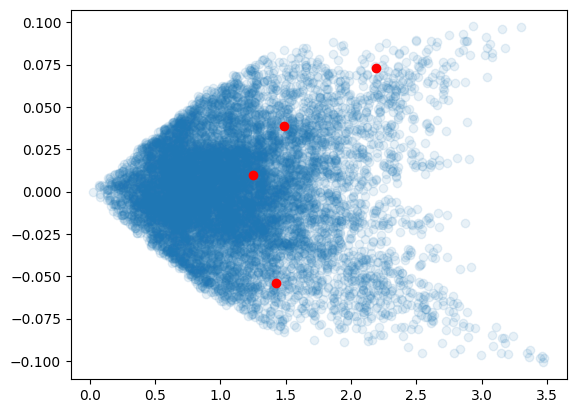

In [26]:
plt.scatter(risks, returns, alpha=0.1)
plt.scatter(single_assets_risks, single_assets_returns, c="red")

In [27]:
for idx, val in cov[["GOOG"]].iteritems():
    print(idx, val)

AttributeError: 'DataFrame' object has no attribute 'iteritems'